<a href="https://colab.research.google.com/github/Danswrang11/Tea-leaf-disease-detection/blob/main/Part_3(classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Pre-Processing

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [ ]:
dataset_path = "/content/drive/MyDrive/Project/Dataset_2"
dataset_dir = pathlib.Path(dataset_path)

In [ ]:
# list of sub directory(class)
class_names = []
for root, dirs, files in os.walk(dataset_path):
    if root != dataset_path:
        x_class = os.path.basename(root)
        if x_class not in class_names:
            class_names.append(x_class)

print(class_names)

['Red leaf spot', 'Brown blight', 'Anthracnose', 'Non tea leaf', 'Algal_spot', 'White spot', 'Birds eye spot', 'Gray blight', 'Healthy']


In [ ]:
# print total number of images in the dataset
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.jpg')))
    print(f"Images in class {class_i}:",image_count)

Images in class Red leaf spot: 864
Images in class Brown blight: 1018
Images in class Anthracnose: 891
Images in class Non tea leaf: 1134
Images in class Algal_spot: 1017
Images in class White spot: 1071
Images in class Birds eye spot: 900
Images in class Gray blight: 900
Images in class Healthy: 981


In [ ]:
# Parameter setting
train_batch = 64
val_batch = 128
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2

In [ ]:
# Load data for Training
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 10198 files belonging to 9 classes.
Using 8159 files for training.


In [ ]:
# Load data for Validation
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                     validation_split=val_split,
                                                     subset="validation",
                                                     seed=123,
                                                     image_size=(img_height, img_width),
                                                     batch_size=val_batch
                                                    )
class_names = train_ds.class_names

Found 10198 files belonging to 9 classes.
Using 2039 files for validation.


In [ ]:
print(class_names)

['Algal_spot', 'Anthracnose', 'Birds eye spot', 'Brown blight', 'Gray blight', 'Healthy', 'Non tea leaf', 'Red leaf spot', 'White spot']


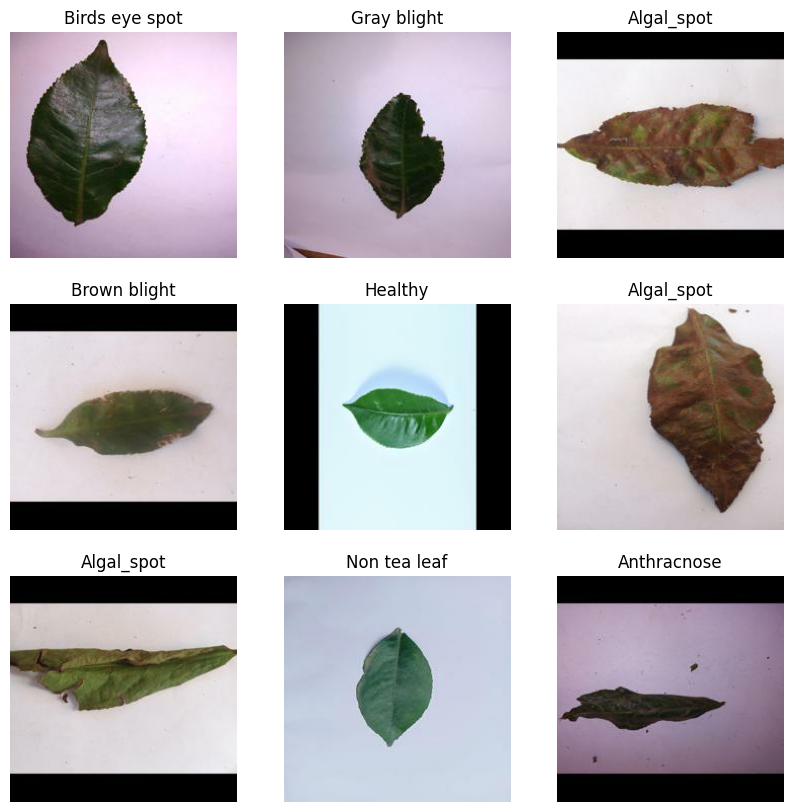

In [ ]:
num_classes=len(class_names)
# Review dataset sample
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Image Classification

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(800).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
## Data augmentation layers to increase data variation for training
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [ ]:
# Model architecture
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])

In [ ]:
# compile model
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 16)        0         
 g2D)                                                 

In [ ]:
epochs=250
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0
)

In [ ]:
model.save('/content/drive/MyDrive/Project/trainmodel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Model Evaluation

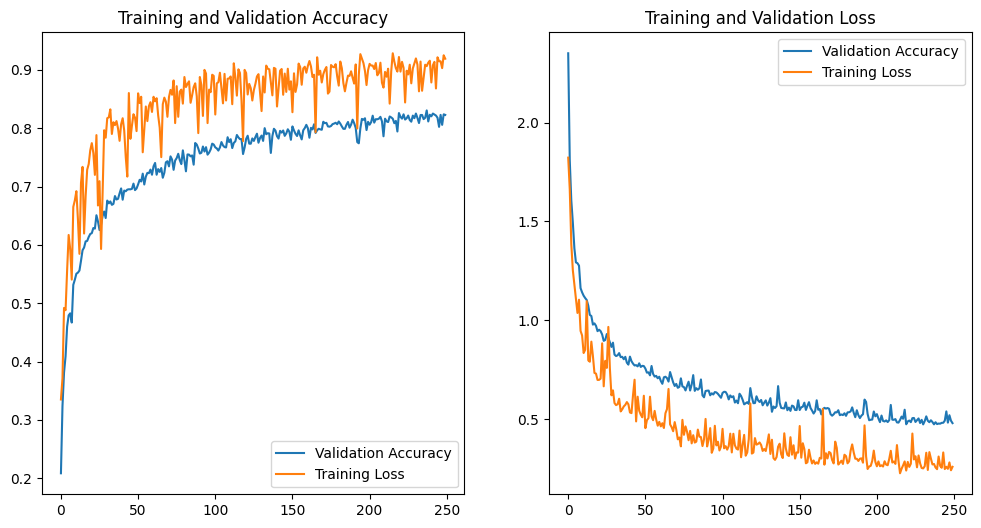

In [ ]:
# Check training result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Validation Accuracy')
plt.plot(epochs_range, val_acc, label='Training Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Validation Accuracy')
plt.plot(epochs_range, val_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [8 0 1 3 5 0 8 3 0 8 0 3 3 1 6 7 1 8 8 6 5 3 2 1 2 5 0 4 5 8 8 7 1 2 8 5 8
 7 8 5 4 6 5 6 7 4 3 0 0 6 1 6 6 5 8 8 2 1 5 7 5 4 8 4 7 3 8 5 3 0 1 3 2 3
 7 3 0 5 8 8 1 7 7 1 0 0 7 0 0 2 8 2 6 3 1 7 8 7 0 7 8 6 7 2 5 5 5 8 4 0 8
 2 4 4 2 6 5 0 4 3 3 7 8 8 3 8 8 7]
Labels:
 [1 0 1 3 5 0 8 3 0 8 0 3 3 2 6 7 1 8 8 6 5 3 2 1 2 5 0 4 5 0 8 7 1 2 8 5 8
 7 8 5 4 6 5 6 0 4 3 0 7 6 4 6 6 5 3 2 2 4 5 1 5 4 8 4 7 3 8 5 3 0 1 3 2 3
 7 3 7 5 8 8 1 7 7 1 0 0 7 0 0 2 3 2 6 7 4 7 8 7 0 7 8 6 7 2 5 5 5 3 4 0 8
 2 4 4 5 6 5 0 4 3 3 7 8 8 3 7 8 7]

              precision    recall  f1-score   support

           0       0.88      0.88      0.88        16
           1       0.64      0.78      0.70         9
           2       0.90      0.82      0.86        11
           3       0.93      0.82      0.87        17
           4       1.00      0.75      0.86        12
           5       1.00      0.94      0.97        17
           6       1.00      1.00      1.00        10
           7       0.

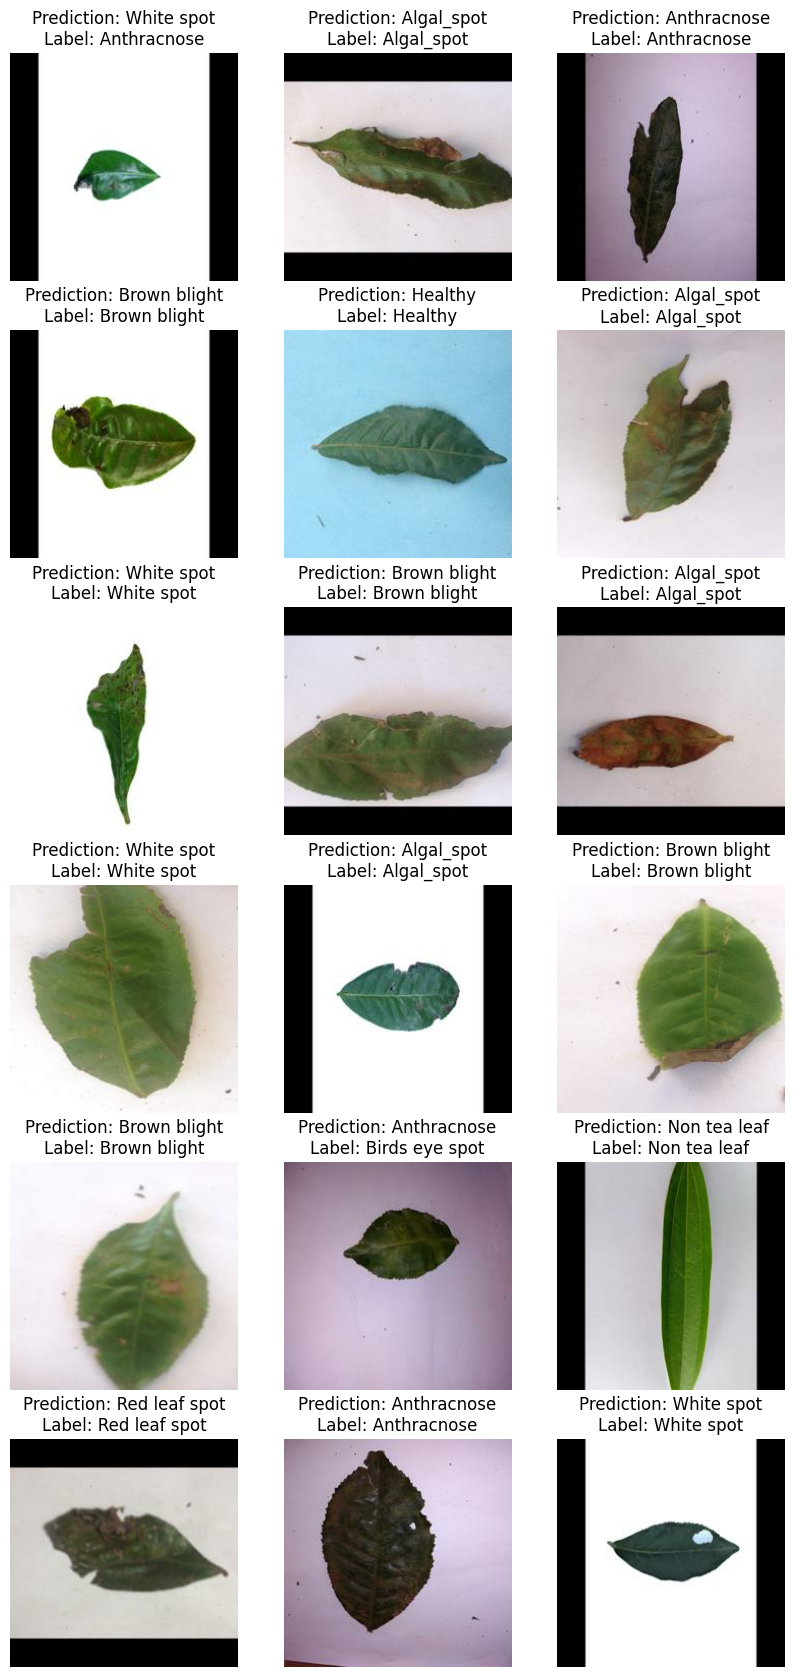

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(18):
    ax = plt.subplot(6, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

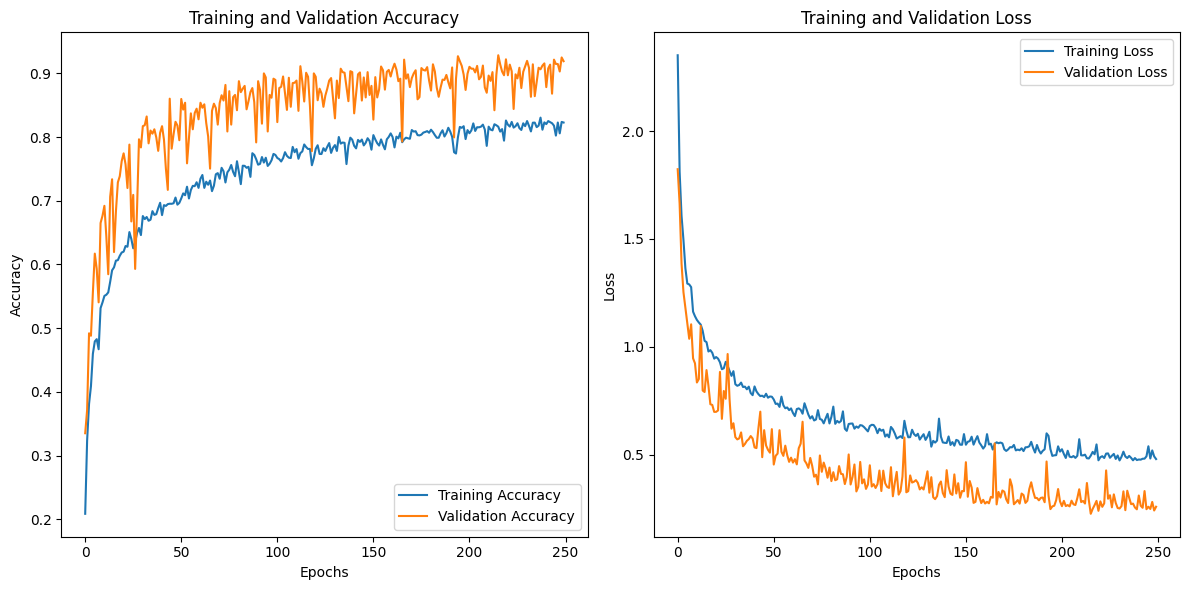

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(12, 6))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
from keras.models import load_model
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
import numpy as np

# Load the model
model = load_model('/content/drive/MyDrive/Project/trainmodel2.h5')

# Load and preprocess the image
image = load_img('/content/drive/MyDrive/Project/Dataset_2/Brown blight/Brown_blight_107.jpg', target_size=(200, 250))
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 200, 250, 3)

# Make predictions
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)

# Map class indices to class names
class_names = ['Anthracnose', 'Non Tea leaf', 'Algal leaf', 'Birds eye spot', 'Brown blight', 'Gray blight', 'Healthy', 'Red leaf spot', 'White spot']  # Update with your class names
predicted_class_name = class_names[predicted_class[0]]

print("Predicted Class:", predicted_class[0])
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 182ms/step
Predicted Class: 4
Predicted Class Name: Brown blight


1/1 [==============================] - 0s 69ms/step


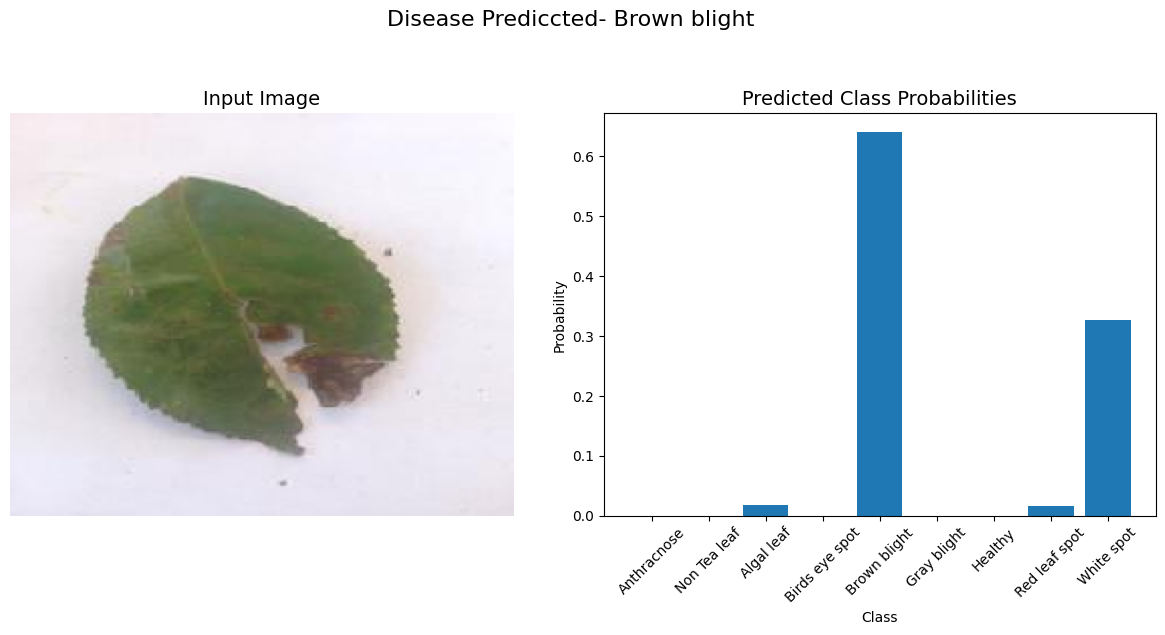

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the model
model = load_model('/content/drive/MyDrive/Project/trainmodel2.h5')

# Load and preprocess the image
image_path = '/content/drive/MyDrive/Project/Dataset_2/Brown blight/Brown_blight_107.jpg'
image = load_img(image_path, target_size=(200, 250))
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 200, 250, 3)

# Make predictions
predictions = model.predict(img)
predicted_class = np.argmax(predictions, axis=1)

# Map class indices to class names
class_names = ['Anthracnose', 'Non Tea leaf', 'Algal leaf', 'Birds eye spot', 'Brown blight', 'Gray blight', 'Healthy', 'Red leaf spot', 'White spot']
predicted_class_name = class_names[predicted_class[0]]

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the image on the left side
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Input Image', fontsize=14)

# Plot the predicted class probabilities on the right side
ax2.bar(class_names, predictions.ravel())
ax2.set_xlabel('Class')
ax2.set_ylabel('Probability')
ax2.set_title('Predicted Class Probabilities', fontsize=14)
ax2.tick_params(axis='x', rotation=45)

# Add the predicted class name as a subtitle
subtitle = f'Disease Prediccted- {predicted_class_name}'
plt.suptitle(subtitle, fontsize=16, y=1.05)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Define your custom model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs= 32
)

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Save the model
model.save("/content/drive/MyDrive/Project")